In [123]:
from griddify import datasets

data = datasets.get_compound_descriptors()

In [124]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

class FeatureDistances(object):

    def __init__(self, metric="euclidean", max_n=10000):
        self.metric = metric
        self.max_n = max_n

    def calculate(self, data):
        D = squareform(pdist(np.array(data).T[:self.max_n,:], metric=self.metric))
        D[np.isnan(D)] = 0
        return D


fd = FeatureDistances().calculate(data)

In [131]:
import numpy as np
from umap import UMAP
from sklearn.preprocessing import StandardScaler, MinMaxScaler


ZSCORE_CLIP = (-5, 5)


class Tabular2Cloud(object):

    def __init__(self, reducer="umap"):
        if type(reducer) is str:
            if reducer == "umap":
                self.reducer = UMAP() # TODO: add more reducers, e.g. tSNE, PCA
            else:
                raise Exception("Reducer {0} is not recognized".format(reducer))
        else:
            self.reducer = reducer
        self.standard_scaler = StandardScaler()
        self.minmax_scaler = MinMaxScaler()
        self.zscore_clip = ZSCORE_CLIP

    def _clip(self, X):
        return np.clip(X, self.zscore_clip[0], self.zscore_clip[1])

    def fit(self, X):
        self.reducer.fit(X)
        Xt = self.reducer.transform(X)
        self.standard_scaler.fit(Xt)
        Xt = self.standard_scaler.transform(Xt)
        Xt = self._clip(Xt) 
        self.minmax_scaler.fit(Xt)

    def transform(self, X):
        Xt = self.reducer.transform(X)
        Xt = self.standard_scaler.transform(Xt)
        Xt = self._clip(Xt)
        Xt = self.minmax_scaler.transform(Xt)
        return Xt


tc = Tabular2Cloud()


In [125]:
from umap import UMAP

reducer = UMAP(metric="precomputed")
reducer.fit(fd)

/home/mduranfrigola/miniconda3/envs/tab2grid/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


UMAP(metric='precomputed', tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt

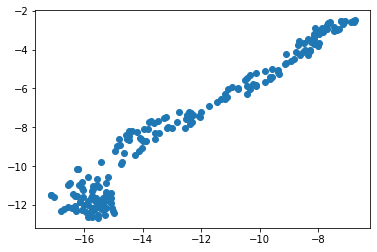

In [127]:
Xc = reducer.transform(fd)
plt.scatter(Xc[:,0], Xc[:,1])

In [128]:
import numpy as np
import lap
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans


GRIDDIFY_METRIC = "sqeuclidean"


class Cloud2Grid(object):

    def __init__(self, max_side=128):
        self._max_side=max_side
        self._clusters=None

    def _is_cloud(self, X):
        if len(X.shape) != 2:
            return False
        if X.shape[1] != 2:
            return False
        return True

    def _find_side(self, X):
        side = int(np.sqrt(X.shape[0]))
        if side > self._max_side:
            side = self._max_side
        return side

    def _needs_downsampling(self, X):
        avail = self._side**2
        assert avail <= X.shape[0]
        if avail == X.shape[0]:
            return False
        else:
            return True

    def _downsample_with_clustering(self, X):
        self._clusters = KMeans(n_clusters=self._side**2)
        self._clusters.fit(X)
        centroids = self._clusters.cluster_centers_
        return centroids

    def _griddify(self, X):
        xv, yv = np.meshgrid(np.linspace(0, 1, self._side), np.linspace(0, 1, self._side))
        self.grid = np.dstack((xv, yv)).reshape(-1, 2)
        cost = cdist(self.grid, X, GRIDDIFY_METRIC)
        cost = cost * (1000000 / cost.max())
        cost = cost.astype(int)
        min_cost, row_assigns, col_assigns = lap.lapjv(cost)
        self._grid_jv = self.grid[col_assigns]
        self._min_cost = min_cost
        self._row_assigns = row_assigns
        self._col_assigns = col_assigns

    def _grid_coordinates_as_integers(self, X):
        X = X*self._side
        X = X.astype(int)
        return X

    def fit(self, X):
        assert self._is_cloud(X)
        self._side = self._find_side(X)
        self._do_cluster = self._needs_downsampling(X)
        if self._do_cluster:
            X = self._downsample_with_clustering(X)
        self._griddify(X)
        self.nearest_neighbors = NearestNeighbors(n_neighbors=1)
        self.nearest_neighbors.fit(X)

    def transform(self, X, as_integers=False):
        assert self._is_cloud(X)
        idxs = self.nearest_neighbors.kneighbors(X, return_distance=False)
        X_grid = np.zeros((X.shape[0], 2))
        for i, idx in enumerate(idxs[:,0]):
            X_grid[i] = self._grid_jv[idx]
        if as_integers:
            return self._grid_coordinates_as_integers(X_grid)
        else:
            return X_grid

cg = Cloud2Grid(max_side=128)
cg.fit(Xc)
Xg = cg.transform(Xc, as_integers=False)

In [129]:
from scipy.spatial.distance import euclidean
import matplotlib as mpl
from matplotlib import cm


def arrows_plot(X_cloud, X_grid, ax, capping_distance=0.5):
    cmap = cm.get_cmap("viridis")
    dists = []
    for start, end in zip(X_cloud, X_grid):
        dists += [euclidean(start, end)]
    norm = mpl.colors.Normalize(vmin=0, vmax=capping_distance)
    values = [norm(x) for x in dists]
    colors = [cmap(x) for x in values]
    i = 0
    for start, end in zip(X_cloud, X_grid):
        color = colors[i]
        ax.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1], head_length=0.01, head_width=0.01, color=color)
        i += 1
    return ax

<AxesSubplot:>

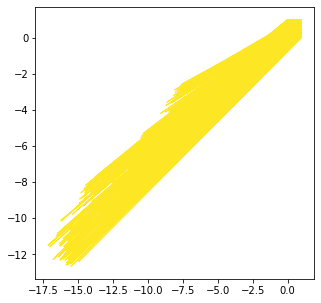

In [130]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

arrows_plot(Xc, Xg, ax=ax, capping_distance=0.5)

In [122]:
Xg = cg.transform(Xc, as_integers=True)

import numpy as np


class Tabular2Grid(object):

    def __init__(self, cloud2grid):
        self._size = cloud2grid._side
        self._empty_grid = cloud2grid.get_empty_grid()
        
    def fit(self, X_grid):
        assert X_grid.astype(int) == X_grid
        self._mapper = X_grid
        
    def transform(self, X):
        Xt = []
        for i in X.shape[0]:
            g = self._empty_grid.copy()
            x = X[i,:]
            for j, v in enumerate(x):
                idx_i, idx_j = self._mapper[j]
                g[idx_i, idx_j] = v
            Xt += [g]
        return np.array(Xt)

tg = Tabular2Grid(cg)
tg.fit(Xg)

AttributeError: 'Cloud2Grid' object has no attribute 'get_empty_grid'

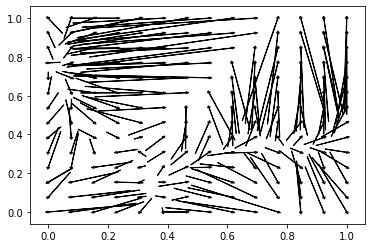

In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(Xc)
Xc = scaler.transform(Xc)

for start, end in zip(Xc, Xg):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

array([[0.69230769, 0.        ],
       [1.        , 0.84615385],
       [1.        , 0.15384615],
       [0.92307692, 0.23076923],
       [0.92307692, 0.30769231],
       [0.84615385, 0.07692308],
       [0.76923077, 0.53846154],
       [0.76923077, 0.23076923],
       [0.76923077, 0.07692308],
       [0.76923077, 0.30769231],
       [0.69230769, 0.23076923],
       [0.69230769, 0.53846154],
       [0.69230769, 0.61538462],
       [0.69230769, 0.69230769],
       [0.84615385, 0.84615385],
       [0.84615385, 0.69230769],
       [0.30769231, 0.76923077],
       [0.84615385, 0.61538462],
       [0.92307692, 0.07692308],
       [0.92307692, 0.61538462],
       [0.84615385, 0.        ],
       [0.92307692, 0.        ],
       [1.        , 0.23076923],
       [1.        , 0.        ],
       [0.76923077, 1.        ],
       [1.        , 0.76923077],
       [0.53846154, 0.30769231],
       [0.53846154, 0.38461538],
       [0.61538462, 0.23076923],
       [0.38461538, 0.30769231],
       [0.